# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

**Resources:**
* Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/

# What we're going to cover 

* Architecture of a neural network *classification* model
* Input shapes and output shapes of a *classification* model (features and labels)
* Creating custom data to view, fit on and predict on
* Steps in modelling
    * Creating a model, setting a loss function and optimizer, creating a training loop, evaluating a model
* Saving and loading models
* Harnessing the power of non-linearity
* Different *classification* evaluation methods

## 1. Make classification data and get it ready

In [197]:
import sklearn

In [198]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)

In [199]:
len(X), len(y)

(1000, 1000)

In [200]:
print(f'First 5 samples of X:\n {X[:5]}')
print(f'First 5 samples of y:\n {y[:5]}')

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [201]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame(
    {
        'X1': X[:, 0],
        'X2': X[:, 1],
        'y': y
    }
)
circles.head(10)

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


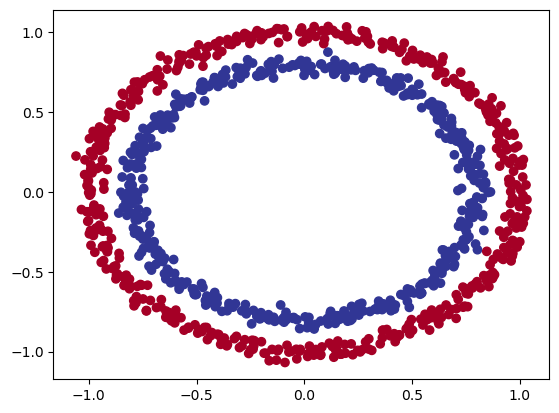

In [202]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.RdYlBu
)

**Note**: The data we're working with is often referred to as a toy dataset, a dataset that is small enought to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [203]:
X.shape, y.shape

((1000, 2), (1000,))

In [204]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [205]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [206]:
import torch
torch.__version__

'2.4.0'

In [207]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [208]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [209]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [210]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
    random_state=42
)

In [211]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [212]:
n_samples

1000

## 2. Building a model

Let's buil a moedl to classifiy our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on a accelerator (GPU) if there is one.
2. Construct a model (bu subclassing nn.Module)
3. Define a loss function and optimizer
4. Creating a training and test loop


In [213]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [214]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [215]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)
        
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [216]:
next(model_0.parameters()).device

device(type='cpu')

In [217]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [218]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [219]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test samples: {len(X_test)}, Shape: {X_test.shape}')
print(f'\nFirst 10 predictions:\n{untrained_preds[:10]}')
print(f'\nFirst 10 labels:\n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [220]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy (cross entropy).

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two fo the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For a definition on what a logit is in deep learning - https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow/52111173#52111173
* For different optimizer see `torch.optim`

In [221]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1)

In [222]:
# Calculate accucacy - out of 100 examples, what percentage does our mdoel get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = ((correct / len(y_pred)) * 100)
    return acc

## 3. Train model

To train our model, we'er going to need to build a training loop

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softamx for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [223]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [224]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [225]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

For our prediction probabilities values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [226]:
# Find the predicted labels
y_preds = torch.round(y_preds_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [227]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs => pred labels
    
    # 2. Calculate loss/accuracy
    # loss = loss_fn(
    #     torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
    #     y_train
    # )
    loss = loss_fn(
        y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
        y_train
    )
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Los backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step() 
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/acc
        test_loss = loss_fn(
            test_logits,
            y_test
        )
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    # Print out what's happening
    if ((epoch % 10) ==  0):
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69796 | Acc: 51.88 | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590 | Acc: 51.25 | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490 | Acc: 51.62 | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435 | Acc: 51.12 | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401 | Acc: 50.88 | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378 | Acc: 50.25 | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362 | Acc: 50.00 | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351 | Acc: 50.25 | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342 | Acc: 49.88 | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336 | Acc: 49.88 | Test loss: 0.69262, Test acc: 53.00%


## 4. Make predictions and evaluate the model

From the metrics if looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, 'Visualize, visualize, visualize!'

To do so, we're going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [228]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path('helper_functions.py').is_file():
    print('helper_functions.py already exists, skipping download')
else:
    print('Download helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


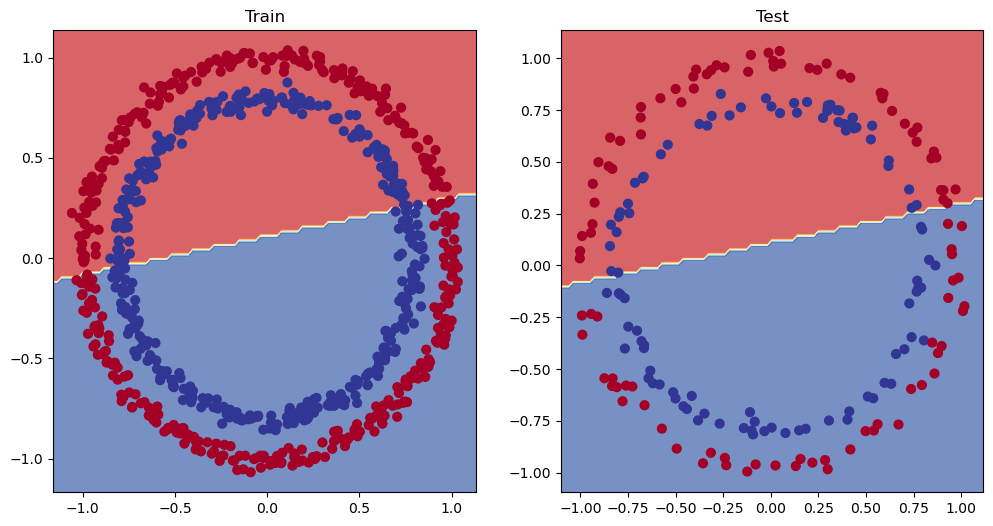

In [229]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model mroe chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rathen than the data.

And because these options are all values we (as machine learning engineers and data scientists) cna change, they are referred as **hyperparameters**.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [230]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [231]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2  = nn.Linear(in_features=10, out_features=10)
        self.layer_3  = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x))) # This way of writing operations leverage speed ups where possible behind the scenes
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [232]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1
)

In [233]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs => pred labels
    
    # 2. Calculate loss/accuracy
    # loss = loss_fn(
    #     torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
    #     y_train
    # )
    loss = loss_fn(
        y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
        y_train
    )
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Los backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step() 
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/acc
        test_loss = loss_fn(
            test_logits,
            y_test
        )
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    # Print out what's happening
    if ((epoch % 100) ==  0):
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69396 | Acc: 50.88 | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305 | Acc: 50.38 | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299 | Acc: 51.12 | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298 | Acc: 51.62 | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298 | Acc: 51.12 | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298 | Acc: 51.00 | Test loss: 0.69468, Test acc: 46.00%


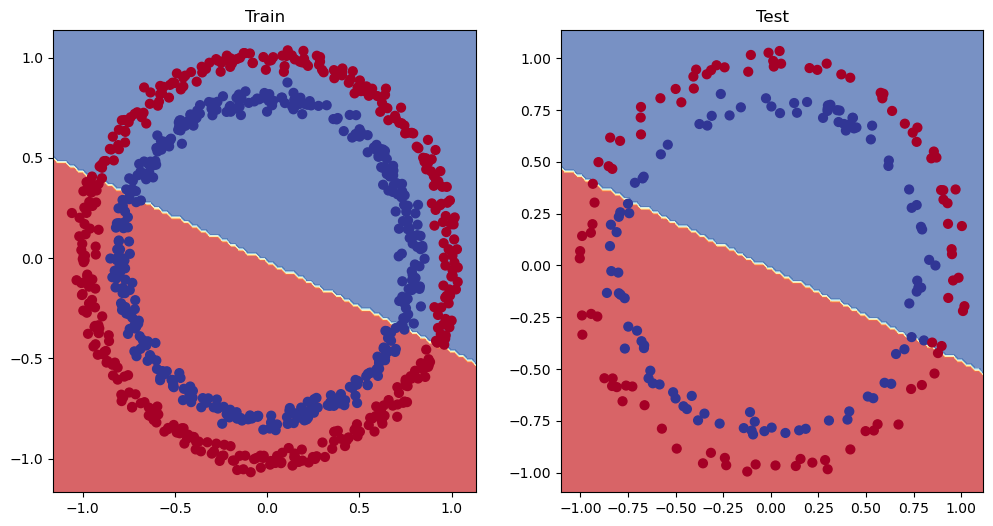

In [234]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [235]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start=start, end=end, step=step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [236]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

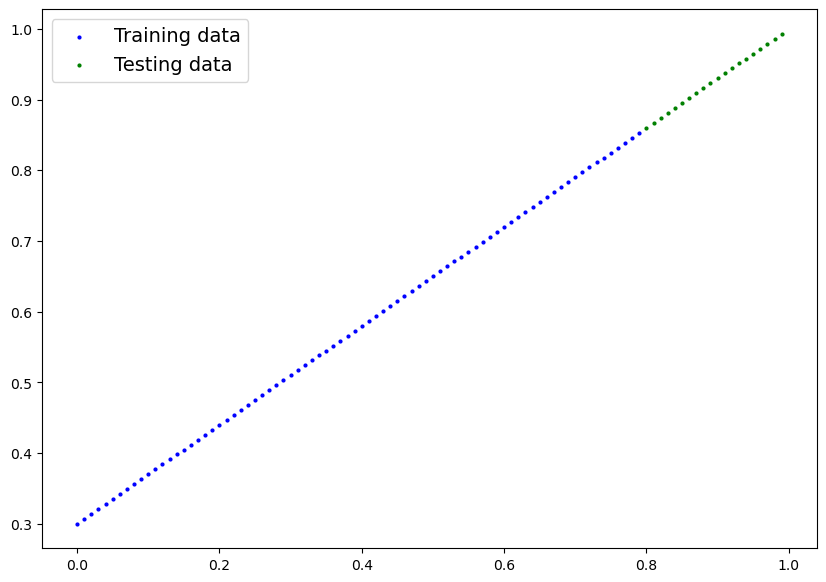

In [237]:
plot_predictions(
    train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
)

### 5.2 Adjusting `model_1` to fit a straight line

In [238]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [239]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(
    model_2.parameters(),
    lr=0.1
)

In [240]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the  data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

### Training
for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 
    
    ### Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
        
    # Print out what's happening
    if ((epoch % 100) ==  0):
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}')

Epoch: 0 | Loss: 0.75986 | Test loss: 0.54143
Epoch: 100 | Loss: 0.09309 | Test loss: 0.02901
Epoch: 200 | Loss: 0.07376 | Test loss: 0.02850
Epoch: 300 | Loss: 0.06745 | Test loss: 0.00615
Epoch: 400 | Loss: 0.06107 | Test loss: 0.02004
Epoch: 500 | Loss: 0.05698 | Test loss: 0.01061
Epoch: 600 | Loss: 0.04857 | Test loss: 0.01326
Epoch: 700 | Loss: 0.06109 | Test loss: 0.02127
Epoch: 800 | Loss: 0.05600 | Test loss: 0.01425
Epoch: 900 | Loss: 0.05571 | Test loss: 0.00603


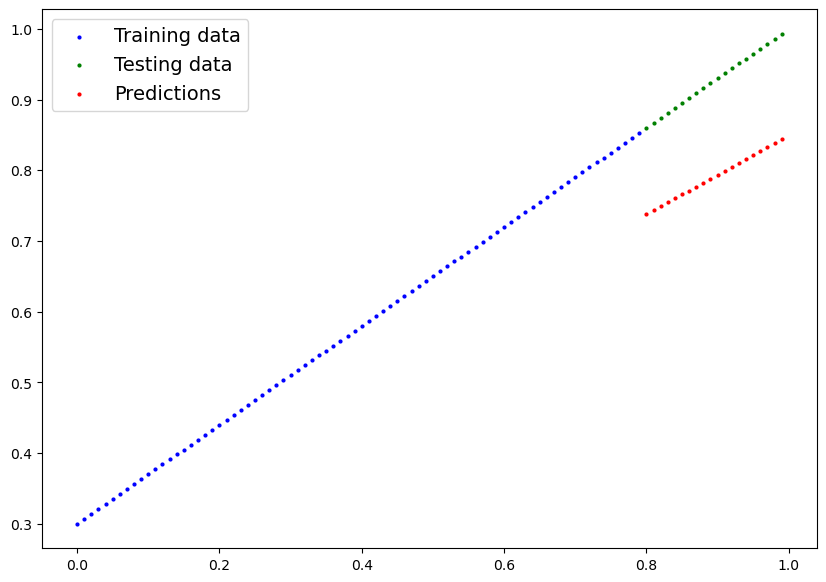

In [241]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)
    
# Plot data and predictions
plot_predictions(
    train_data=X_train_regression.cpu(), 
    train_labels=y_train_regression.cpu(),
    test_data=X_test_regression.cpu(),
    test_labels=y_test_regression.cpu(),
    predictions=y_preds.cpu().detach().numpy()
)

## 6. The missing piece: non-linearity

'What patterns could you draw if you were given an infitnite amount of a straight and non-straight lines?'

Our in machine learning terms, an infinite (but really it 's finite) of linear and non-linear functions?

https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

### 6.1 Recreating non-linear data (red and blue)

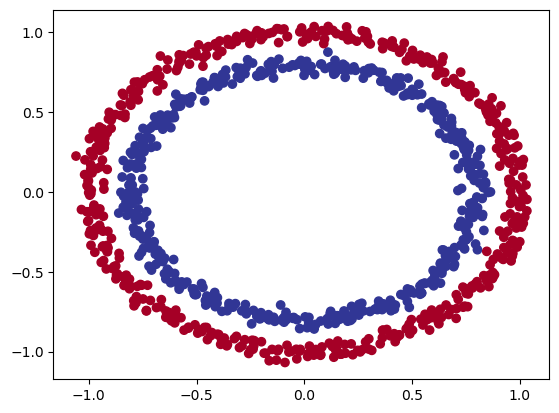

In [242]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [243]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

* Linear = straight lines
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [244]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # relu is a non-linear activation function
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # Where should we put out non-linear activation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [245]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    model_3.parameters(),
    lr=0.1
)

### 6.3 Training a model with non-linearity

In [246]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_3.train()
    
    # 1. Forward
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction prob -> prediction labels
    
    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Step the optimizer
    optimizer.step() 
    
    ### Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    # Print out what's happening
    if ((epoch % 100) ==  0):
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}')

Epoch: 0 | Loss: 0.69295, Acc: 50.00 | Test loss: 0.6932, Test Acc: 50.00
Epoch: 100 | Loss: 0.69115, Acc: 52.88 | Test loss: 0.6910, Test Acc: 52.50
Epoch: 200 | Loss: 0.68977, Acc: 53.37 | Test loss: 0.6894, Test Acc: 55.00
Epoch: 300 | Loss: 0.68795, Acc: 53.00 | Test loss: 0.6872, Test Acc: 56.00
Epoch: 400 | Loss: 0.68517, Acc: 52.75 | Test loss: 0.6841, Test Acc: 56.50
Epoch: 500 | Loss: 0.68102, Acc: 52.75 | Test loss: 0.6794, Test Acc: 56.50
Epoch: 600 | Loss: 0.67515, Acc: 54.50 | Test loss: 0.6729, Test Acc: 56.00
Epoch: 700 | Loss: 0.66659, Acc: 58.38 | Test loss: 0.6632, Test Acc: 59.00
Epoch: 800 | Loss: 0.65160, Acc: 64.00 | Test loss: 0.6476, Test Acc: 67.50
Epoch: 900 | Loss: 0.62362, Acc: 74.00 | Test loss: 0.6215, Test Acc: 79.00


### 6.4 Evaluating a model trained with non-linear activation functions

In [247]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
    
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

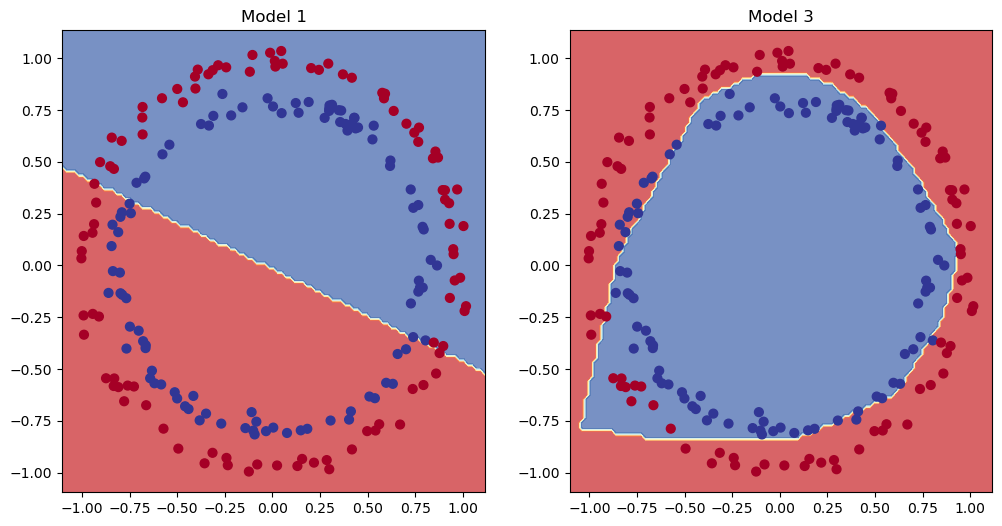

In [248]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Model 1')
plot_decision_boundary(model_1, X_test, y_test) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title('Model 3')
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

**Challenge**: Can you improve model_3 to do better than 80% accuracy on the test data?

## 7. Replicating non-linear activation functions

Nueral networks, rather than us telling the model what to learn, we give it the tools to discover patterns in dara and it tries to figure out the best patterns on its own.

And these tools are linear & non-linear functions.

In [249]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

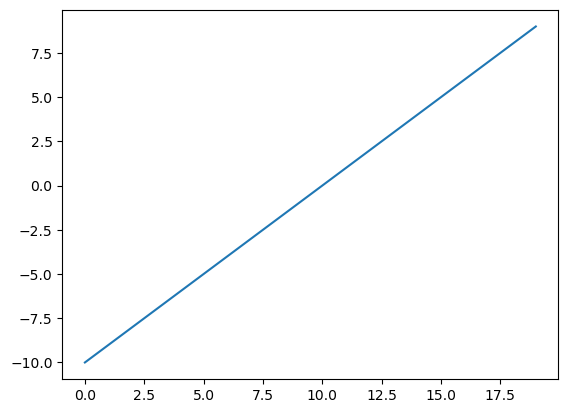

In [250]:
# Visualize the tensor
plt.plot(A)


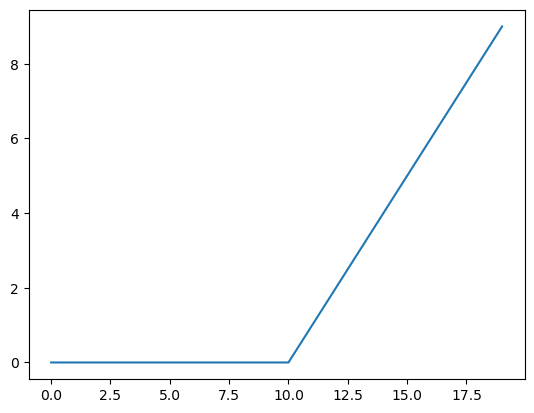

In [251]:
plt.plot(torch.relu(A))

In [252]:
def relu(x):
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors
                         
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

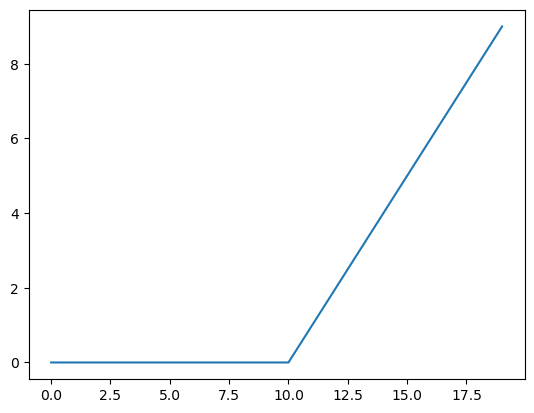

In [253]:
# Plot ReLU activation function
plt.plot(relu(A))

In [254]:
# Now let's do the same for Sigmoid = https://pytorch.org/docs/stable/generated/torch.sigmoid.html
def sigmoid(x):
    return (1 / (1 + torch.exp(-x)))

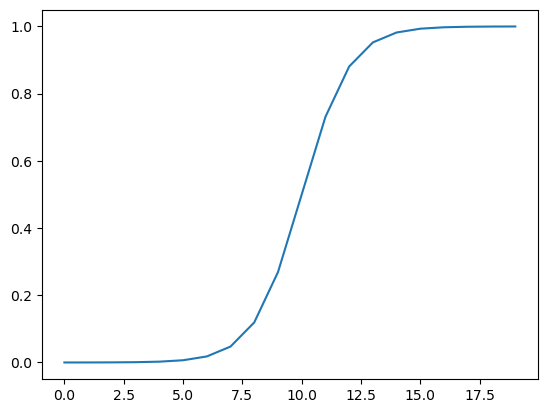

In [255]:
plt.plot(torch.sigmoid(A))

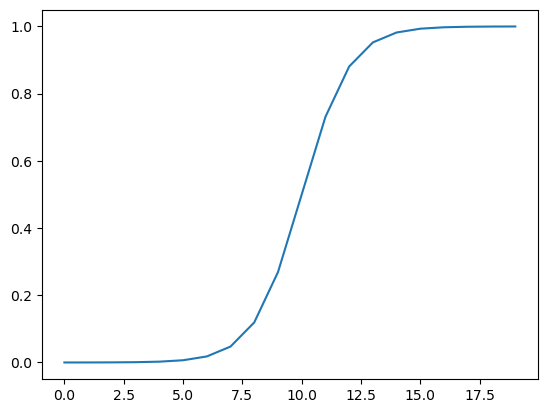

In [256]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs dog, spam vs not spam, fraud or not fraud)
* Multi-class classfication = more than one thing or another (cat vs dog vs chicken)

### 8.1 Creating a toy multi-class dataset


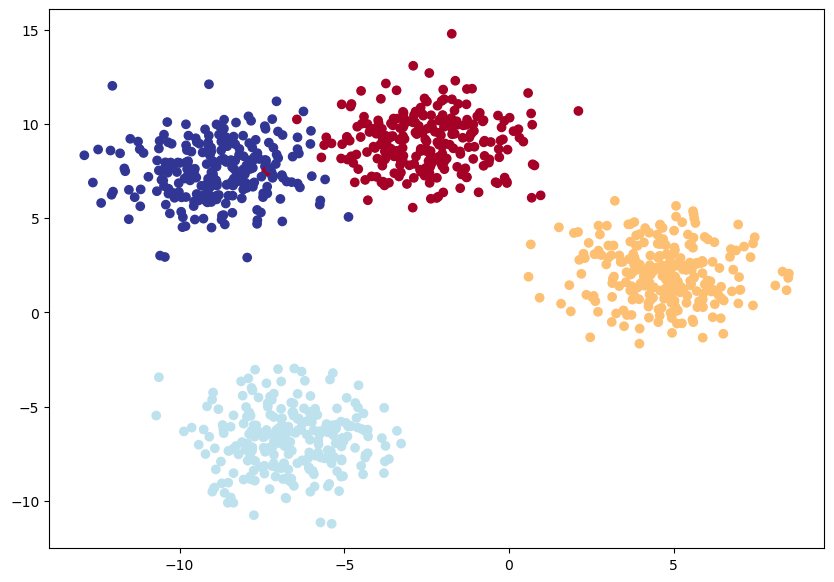

In [257]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create mulit-class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES,
    centers=NUM_CLASSES,
    cluster_std=1.5, # give the clusters a little shake up
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data (visualize, visualize, visualize)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [258]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [259]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        '''
        Initializes a multi-class classification model.
        
        Args:
            input_features (int): Number of input features to the model
            input_features (int): Number of output features (number of output classes)
            hidden units (int): Number of hidden units between layer, default 8
        '''
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)

# Createa an instance of BlobModel and send it to the target device    
model_4 = BlobModel(
    input_features=2,
    output_features=4,
    hidden_units=8
).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and an optimizer for a multi-class classification model


In [260]:
# Create a loss function for multi-class classification - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD( 
    params=model_4.parameters(),
    lr=0.1 # learning rate is a hyperparameter you can change
)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred probs (use `torch.softmax) -> Pred labels (take the argmax of the prediction probabilities)

In [261]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
    
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [262]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [263]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [264]:
torch.sum(y_pred_probs[0])

tensor(1.0000)

In [265]:
torch.max(y_pred_probs[0])

tensor(0.3244)

In [266]:
torch.argmax(y_pred_probs[0])

tensor(1)

In [267]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.max(y_pred_probs, dim=1)
y_preds

torch.return_types.max(
values=tensor([0.3244, 0.3336, 0.3011, 0.3078, 0.3719, 0.3381, 0.2867, 0.3554, 0.3009,
        0.3595, 0.3496, 0.3588, 0.3688, 0.3644, 0.3708, 0.3358, 0.3332, 0.2996,
        0.3450, 0.3284, 0.3434, 0.3436, 0.3120, 0.2962, 0.3011, 0.3025, 0.3389,
        0.3727, 0.3170, 0.3547, 0.3309, 0.3177, 0.3088, 0.3374, 0.3667, 0.3011,
        0.3039, 0.3340, 0.3482, 0.2989, 0.3442, 0.3291, 0.3393, 0.3011, 0.3504,
        0.3528, 0.3196, 0.3402, 0.3415, 0.3519, 0.3030, 0.3454, 0.3238, 0.3070,
        0.3383, 0.3006, 0.3121, 0.3106, 0.3420, 0.3011, 0.3018, 0.3458, 0.3301,
        0.3024, 0.3011, 0.3553, 0.3772, 0.3397, 0.3319, 0.3409, 0.3454, 0.3457,
        0.3373, 0.3461, 0.3011, 0.3434, 0.3320, 0.3507, 0.3413, 0.3053, 0.3667,
        0.3011, 0.3344, 0.3017, 0.3358, 0.3375, 0.3011, 0.3248, 0.3333, 0.3011,
        0.3396, 0.3307, 0.3367, 0.3360, 0.3335, 0.3337, 0.3121, 0.3426, 0.3386,
        0.3011, 0.3449, 0.3479, 0.3458, 0.3558, 0.3011, 0.3434, 0.3073, 0.3504,
        0

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [268]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epoch = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data 
for epoch in range(epochs):
    ### Training
    model_4.train()
    
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    print(y_logits.shape)
    print(y_train.shape)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)
        
        # Print out what's happening
        if (epoch % 10) == 0:
            print(f'Epoch: {epoch} | Loss: {loss:4f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')

torch.Size([800, 4])
torch.Size([800])
Epoch: 0 | Loss: 1.158827, Acc: 40.38 | Test loss: 1.0755, Test acc: 48.00%
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
Epoch: 10 | Loss: 0.644755, Acc: 96.75 | Test loss: 0.6607, Test acc: 97.50%
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
torch.Size([800, 4])
torch.Size([800])
Epoch: 20 | Loss: 0.425352, 

### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [269]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -2.3751,  10.9387, -10.2038, -11.3270],
        [ -2.1934,  -9.4839,  -6.3062,   5.2289],
        [ -4.9855,  -5.3790,   5.3840,  -4.3115],
        [ -3.0428,   8.1532,  -5.4971,  -6.6867],
        [  6.4903,  -2.8975, -12.3324,  -8.4675],
        [ -2.7723, -11.1927,  -7.4741,   6.3901],
        [ -4.3608,  -4.5814,   4.6891,  -3.5910],
        [  5.8017,  -6.8308,  -9.7351,  -4.1265],
        [ -6.3789,  -6.9228,   6.6639,  -5.5251],
        [  6.2822,  -5.5357, -10.3558,  -5.4748]])

In [270]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.6515e-06, 1.0000e+00, 6.5754e-10, 2.1385e-10],
        [5.9742e-04, 4.0741e-07, 9.7747e-06, 9.9939e-01],
        [3.1371e-05, 2.1165e-05, 9.9989e-01, 6.1552e-05],
        [1.3729e-05, 9.9998e-01, 1.1796e-06, 3.5901e-07],
        [9.9992e-01, 8.3726e-05, 6.6888e-09, 3.1906e-07],
        [1.0490e-04, 2.3112e-08, 9.5246e-07, 9.9989e-01],
        [1.1735e-04, 9.4120e-05, 9.9954e-01, 2.5340e-04],
        [9.9995e-01, 3.2639e-06, 1.7882e-07, 4.8777e-05],
        [2.1657e-06, 1.2571e-06, 9.9999e-01, 5.0863e-06],
        [9.9998e-01, 7.3709e-06, 5.9454e-08, 7.8339e-06]])

In [271]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [272]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

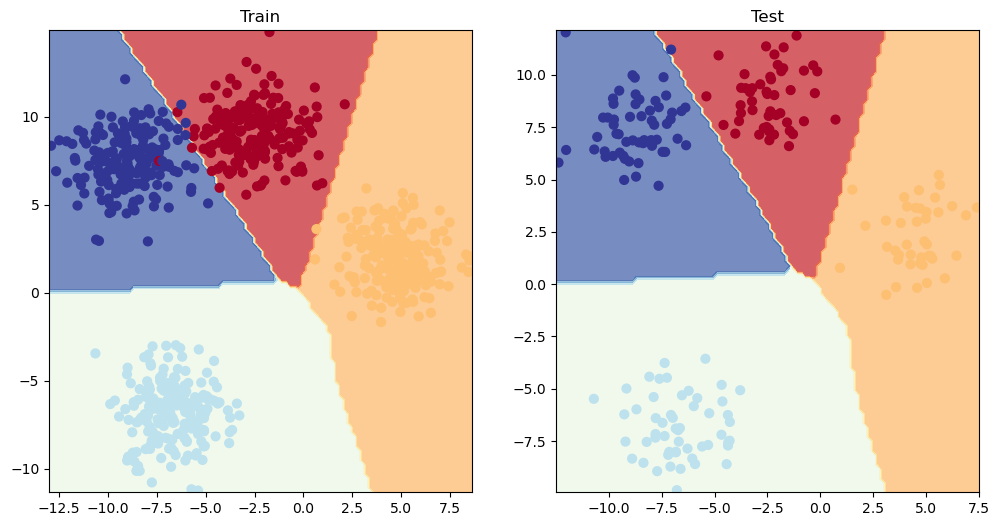

In [273]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

See this article for when to use precision/recall - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

If you want access to a lot of PyTorch metrics, see TorchMetrics

In [274]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)

## Exercises & Extra-curriculum

### 1. Make a binary classification dataset with Scikit-Learn's make_moons() function

* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [292]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_moons(
    n_samples,
    noise=0.03,
    random_state=42
)

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
    random_state=42
)

In [293]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

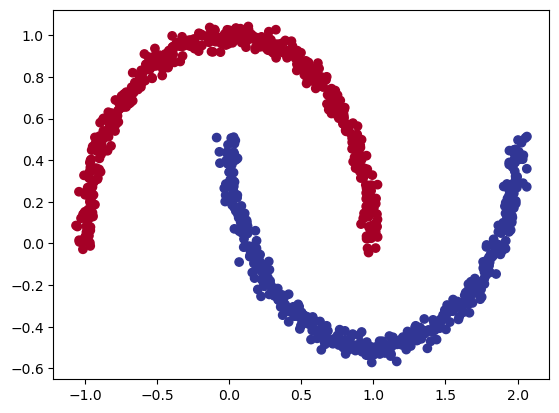

In [294]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [295]:
class CustomModel(nn.Module):
    def __init__(self, input_features:int, output_features:int, hidden_units:int=8):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units)
        self.layer_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer_3 = nn.Linear(in_features=hidden_units, out_features=output_features)
        self.relu = nn.ReLU()
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
custom_model = CustomModel(
    input_features=2,
    output_features=1,
    hidden_units=8
).to(device)
custom_model

CustomModel(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)

### 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [296]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    custom_model.parameters(),
    lr=0.1
)

### 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

* To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [297]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 700

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data 
for epoch in range(epochs):
    ### Training
    custom_model.train()
    
    y_logits = custom_model(X_train).squeeze()
    # y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction prob -> prediction labels
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ### Testing
    custom_model.eval()
    with torch.inference_mode():
        test_logits = custom_model(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
        
        # Print out what's happening
        if (epoch % 10) == 0:
            print(f'Epoch: {epoch} | Loss: {loss:4f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.711974, Acc: 50.00 | Test loss: 0.7055, Test acc: 50.00%
Epoch: 10 | Loss: 0.690191, Acc: 61.00 | Test loss: 0.6880, Test acc: 64.50%
Epoch: 20 | Loss: 0.679143, Acc: 80.38 | Test loss: 0.6787, Test acc: 84.00%
Epoch: 30 | Loss: 0.666245, Acc: 83.88 | Test loss: 0.6668, Test acc: 84.50%
Epoch: 40 | Loss: 0.646757, Acc: 81.88 | Test loss: 0.6484, Test acc: 82.50%
Epoch: 50 | Loss: 0.617324, Acc: 81.12 | Test loss: 0.6206, Test acc: 81.50%
Epoch: 60 | Loss: 0.575278, Acc: 81.12 | Test loss: 0.5808, Test acc: 81.50%
Epoch: 70 | Loss: 0.520593, Acc: 81.88 | Test loss: 0.5288, Test acc: 81.00%
Epoch: 80 | Loss: 0.460072, Acc: 82.88 | Test loss: 0.4709, Test acc: 82.00%
Epoch: 90 | Loss: 0.404305, Acc: 83.75 | Test loss: 0.4170, Test acc: 82.00%
Epoch: 100 | Loss: 0.360941, Acc: 85.00 | Test loss: 0.3743, Test acc: 83.50%
Epoch: 110 | Loss: 0.329567, Acc: 85.38 | Test loss: 0.3424, Test acc: 84.50%
Epoch: 120 | Loss: 0.306799, Acc: 85.75 | Test loss: 0.3184, Test acc: 84.5

### 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

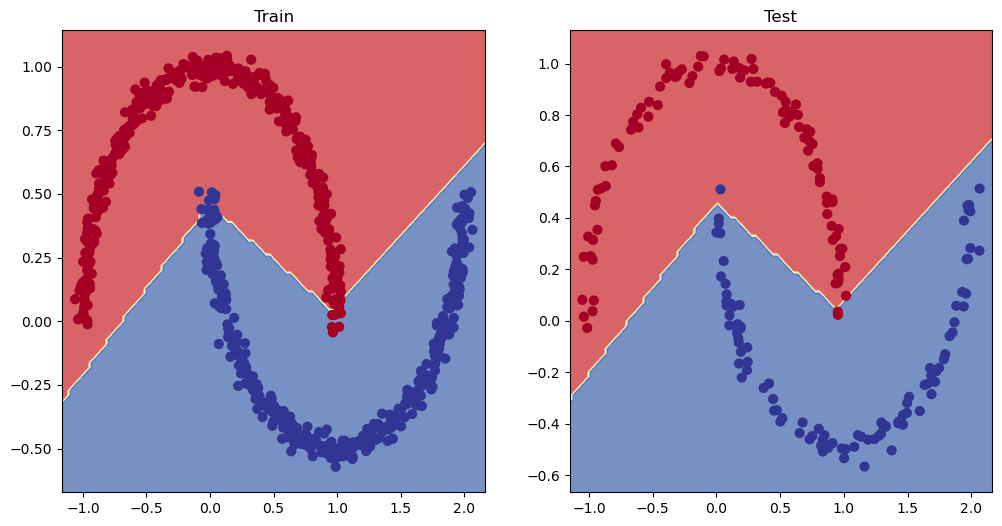

In [298]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(custom_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(custom_model, X_test, y_test)

### 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

* Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

In [299]:
def tanh(x:torch.Tensor) -> torch.Tensor:
    return ((torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x)))

### 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).

* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

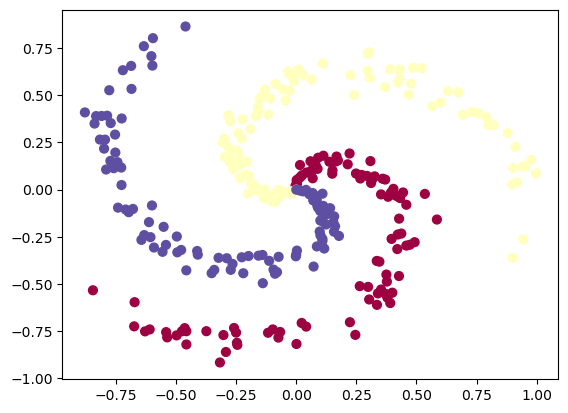

In [300]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [301]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
    random_state=42
)

In [306]:
custom_model_2 = CustomModel(
    input_features=2,
    output_features=3,
    hidden_units=8
).to(device)
custom_model_2

CustomModel(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=3, bias=True)
  (relu): ReLU()
)

In [307]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    custom_model_2.parameters(),
    lr=0.01
)

In [308]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 700

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data 
for epoch in range(epochs):
    ### Training
    custom_model_2.train()
    
    y_logits = custom_model_2(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ### Testing
    custom_model_2.eval()
    with torch.inference_mode():
        test_logits = custom_model_2(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)
        
        # Print out what's happening
        if (epoch % 10) == 0:
            print(f'Epoch: {epoch} | Loss: {loss:4f}, Acc: {acc:.2f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 1.103312, Acc: 32.50 | Test loss: 1.0866, Test acc: 36.67%
Epoch: 10 | Loss: 1.051289, Acc: 41.67 | Test loss: 1.0587, Test acc: 38.33%
Epoch: 20 | Loss: 0.976154, Acc: 55.42 | Test loss: 1.0084, Test acc: 46.67%
Epoch: 30 | Loss: 0.890594, Acc: 50.00 | Test loss: 0.9390, Test acc: 41.67%
Epoch: 40 | Loss: 0.809352, Acc: 55.00 | Test loss: 0.8708, Test acc: 48.33%
Epoch: 50 | Loss: 0.738145, Acc: 62.50 | Test loss: 0.8197, Test acc: 56.67%
Epoch: 60 | Loss: 0.681126, Acc: 62.50 | Test loss: 0.7872, Test acc: 58.33%
Epoch: 70 | Loss: 0.634677, Acc: 60.42 | Test loss: 0.7357, Test acc: 61.67%
Epoch: 80 | Loss: 0.579571, Acc: 65.42 | Test loss: 0.6739, Test acc: 65.00%
Epoch: 90 | Loss: 0.528019, Acc: 68.75 | Test loss: 0.6153, Test acc: 70.00%
Epoch: 100 | Loss: 0.483986, Acc: 71.67 | Test loss: 0.5714, Test acc: 70.00%
Epoch: 110 | Loss: 0.449066, Acc: 74.58 | Test loss: 0.5447, Test acc: 76.67%
Epoch: 120 | Loss: 0.423437, Acc: 76.25 | Test loss: 0.5292, Test acc: 76.6

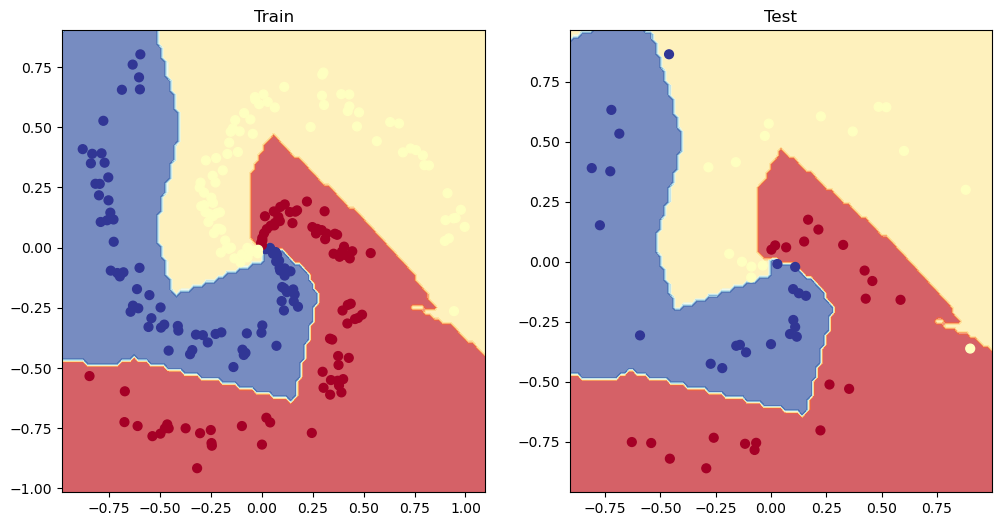

In [309]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(custom_model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(custom_model_2, X_test, y_test)